In [3]:
import torch
import torchvision

from torch.utils.mobile_optimizer import optimize_for_mobile
print(f'PyTorch version: {torch.version.__version__}')
print(f'PyTorch version: {torchvision.version.__version__}')
class ChannelsLastModel(torch.nn.Module):
    def __init__(self, m):
        super(ChannelsLastModel, self).__init__()
        self.m = m
    def forward(self, x):
        return self.m(x.contiguous(memory_format=torch.channels_last))
torch.backends.quantized.engine='qnnpack'
for model_name in ['mobilenet_v2']:
    print(model_name, " quantized")
    m = torchvision.models.quantization.__dict__[model_name](pretrained=False, quantize=True)
    #m.qconfig = torch.quantization.get_default_qconfig('qnnpack')
    m.eval()
    model = ChannelsLastModel(m)
    model.eval()
    script_model = torch.jit.script(model)
    script_model_optimized = optimize_for_mobile(script_model)
    torch.jit.save(script_model_optimized, model_name + "_quant.pt")

PyTorch version: 1.6.0a0+359ffb6
PyTorch version: 0.6.0a0+35d732a
mobilenet_v2  quantized


/home/zafar/Git/pytorch-dev/pytorch-adaptive-avgpool3d/torch/nn/quantized/modules/utils.py:10: UserWarning: 0quantize_tensor_per_tensor_affine current rounding mode is not set to round-to-nearest-ties-to-even (FE_TONEAREST). This will cause accuracy issues in quantized models. (Triggered internally at  /home/zafar/Git/pytorch-dev/pytorch-adaptive-avgpool3d/aten/src/ATen/native/quantized/affine_quantizer.cpp:25.)
  float(wt_scale), int(wt_zp), torch.qint8)
/home/zafar/Git/pytorch-dev/pytorch-adaptive-avgpool3d/torch/quantization/observer.py:144: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  Returning default scale and zero point "


In [25]:
min([1,2,3])

1

[0.0, 20.0, 40.0, 60.0, 22, 31, 40]
[0.0, 0.2, 0.4000000000000001, 0.6000000000000001, 0.8, 1.0000000000000002, 0.5, 0.75, 0.9]


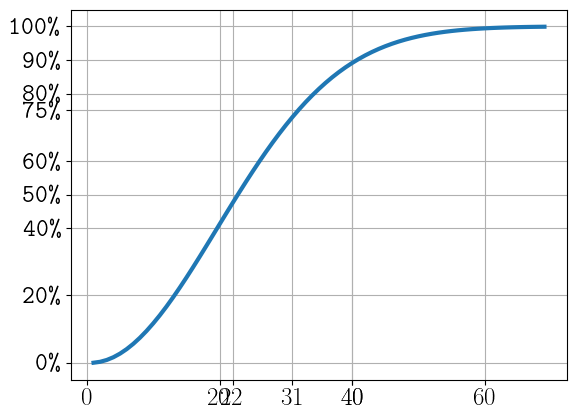

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def make_paradox_list(total_num_entries):
    starting_num = total_num_entries
    no_coincidence_ratio = 1.0
    coincide_list = [1.0 - no_coincidence_ratio]
    for idx in range(1, total_num_entries+1):
        no_coincidence_ratio *= (total_num_entries - idx) / total_num_entries
        coincidence_ratio = 1.0 - no_coincidence_ratio
        coincide_list.append(coincidence_ratio)
    return coincide_list

def binary_search(lst, target, closest=False, round_to=None):
    # Either return a single index or two indices if the result is in between
    # If closest is set, return the closest index if the result is in between
    # If round_to is set, it rounds the list element before comparing to target
    start = 0
    end = len(lst) - 1
    round_fn = lambda x: x
    if round_to is not None:
        round_fn = lambda x: round(x, round_to)
    
    while end > start:
        if target <= round_fn(lst[start]):
            mid = start
            break
        if target >= round_fn(lst[end]):
            mid = end
            break
        mid = (end + start) // 2
        if target == round_fn(lst[mid]):
            return mid
        if target < round_fn(lst[mid]):
            end = mid - 1
        elif target > round_fn(lst[mid]):
            start = mid + 1
    pair = False
    if mid > 0 and target < round_fn(lst[mid]):
        mid = (mid - 1, mid)
        pair = True
    elif mid < (len(lst) - 1) and target > round_fn(lst[mid]):
        pair = True
        mid = (mid, mid + 1)
    if closest and pair:
        if abs(target - lst[mid[0]]) < abs(target - lst[mid[1]]):
            return mid[0]
        else:
            return mid[1]
    return mid

def plot_paradox(point_list, cutoff=None, highlight_levels=[], ax=None):
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    if cutoff is not None:
        end = binary_search(point_list, cutoff, True, 6)
        end = min(end+1, len(point_list))
        point_list = point_list[:end]
    x_range = range(1, len(point_list) + 1)
    ax.plot(x_range, point_list)
    extray = []
    extrax = []
    for lvl in highlight_levels:
        # Search by value, there are guarantees that the array is sorted
        if point_list[0] > lvl or point_list[-1] < lvl:
            continue
        x_closest = binary_search(point_list, lvl, True, 6)
        extrax.append(x_closest)
        extray.append(lvl)
    xticks = list(ax.get_xticks())
    yticks = list(ax.get_yticks())
    if xticks[0] < min(x_range):
        xticks = xticks[1:]
    if xticks[-1] > max(x_range):
        xticks = xticks[:-1]
    if yticks[0] < min(point_list):
        yticks = yticks[1:]
    if yticks[-1] > max(point_list):
        yticks = yticks[:-1]
    xticks = xticks + extrax
    yticks = yticks + extray
    
    print(xticks)
    print(yticks)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.grid()
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
        

bd_list = make_paradox_list(365)
plot_paradox(bd_list, cutoff=0.999, highlight_levels=[0.5, 0.75, 0.9])


# plt.plot(bd_list)
# ax = plt.gca()
# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.grid()

# yticks = list(plt.yticks()[0])
# if yticks[0] < min(bd_list):
#     yticks = yticks[1:]
# if yticks[-1] > max(bd_list):
#     yticks = yticks[:-1]
# yticks.append(0.5)
# plt.yticks(yticks)

# print(plt.yticks())